In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import numpy as np

import glob
from os import path, getcwd
import utils
from matplotlib import pyplot as plt
%matplotlib inline

directory='data'

### Collate Data

In [2]:
crs = 'PROJCS["OSGB_1936_British_National_Grid",GEOGCS["GCS_OSGB 1936",DATUM["D_OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["Meter",1]]'

# house_prices=pd.read_csv(path.join(directory,'HousePrices/house_prices_full_local.csv'))
house_prices=pd.read_csv(path.join(directory,'house_prices_full_backup.csv'))

house_prices=gpd.GeoDataFrame(house_prices,
                              geometry=gpd.points_from_xy(house_prices['x'],house_prices['y']),
                              crs=crs)

In [56]:
roads=gpd.read_file(path.join(directory,'os_roads_local.shp'))
greenspaces=gpd.read_file(path.join(directory,'os_greenspaces_local.shp'))
rivers=gpd.read_file(path.join(directory,'os_rivers_local.shp'))

In [4]:
railways=gpd.read_file(path.join(directory,'railway_noise.shp'))
noisy_roads=gpd.read_file(path.join(directory,'road_noise.shp'))
end_noise=gpd.read_file(path.join(directory,'end_noise.shp'))

In [5]:
train_stations = pd.read_csv(path.join(directory,'NaPTANcsv/RailReferences.csv'), encoding='Latin')
train_stations = train_stations[['AtcoCode','StationName','CrsCode','Easting', 'Northing']]
train_stations = train_stations[(train_stations['Easting']>520000) & (train_stations['Easting']<575000) \
                      & (train_stations['Northing']>235000) & (train_stations['Northing']<280000)]
train_stations=gpd.GeoDataFrame(train_stations,
                                geometry=gpd.points_from_xy(train_stations['Easting'],train_stations['Northing']),
                                crs=crs) 

In [6]:
bus_stops = pd.read_csv(path.join(directory,'NaPTANcsv/Stops.csv'), encoding='Latin')
bus_stops = bus_stops[['NaptanCode','CommonName','Easting', 'Northing','Indicator']]
bus_stops = bus_stops[(bus_stops['Easting']>520000) & (bus_stops['Easting']<575000) \
                      & (bus_stops['Northing']>235000) & (bus_stops['Northing']<280000)]
bus_stops=gpd.GeoDataFrame(bus_stops,
                           geometry=gpd.points_from_xy(bus_stops['Easting'],bus_stops['Northing']),
                           crs=crs) 

/home/millerdw/anaconda3/envs/geopython/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,2,5,6,7,9,11,13,15,20,21,22,23,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
airport_coords = pd.read_csv(path.join(directory,'Custom/CambridgeAirport.csv'))
runway_coords = pd.read_csv(path.join(directory,'Custom/CambridgeRunway.csv'))

# crs = {'init': 'epsg:4326'}
airport = gpd.GeoDataFrame(index=[0], 
                           geometry=[Polygon(zip(airport_coords['X (Easting)'], airport_coords['Y (Northing)']))],
                           crs=crs)
runway = gpd.GeoDataFrame(index=[0], 
                          geometry=[LineString(zip(runway_coords['X (Easting)'], runway_coords['Y (Northing)']))],
                          crs=crs)

In [ ]:
## merge hpi average prices and 1m changes to previous month (not enough?) before transaction 

## Generate Dataset

In [10]:
house_prices['min_dist_airport']=house_prices.geometry.apply(lambda house: airport.geometry.distance(house))
house_prices['min_dist_runway']=house_prices.geometry.apply(lambda house: runway.geometry.distance(house))
house_prices['min_dist_railway']=house_prices.geometry.apply(lambda house: railways.geometry.distance(house).min())

In [15]:
house_prices['inv_sq_dist_airport']=house_prices.min_dist_airport.apply(lambda dist: dist**(-2))
house_prices['inv_sq_dist_runway']=house_prices.min_dist_runway.apply(lambda dist: dist**(-2))
house_prices['inv_sq_dist_railway']=house_prices.min_dist_railway.apply(lambda dist: 1 if dist<1 else dist**(-2))
# house_prices['inv_sq_dist_roads']=house_prices.geometry.apply(lambda house: roads.geometry.distance(house).min()**(-2))

In [56]:
house_prices.to_csv(path.join(directory,'house_prices_full_backup.csv'))

In [10]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
house_prices['min_dist_station']=house_prices.geometry.parallel_apply(lambda house: train_stations.geometry.distance(house).min())

In [12]:
house_prices['min_dist_bus']=house_prices.geometry.parallel_apply(lambda house: bus_stops.geometry.distance(house).min())

In [13]:
house_prices.to_csv(path.join(directory,'house_prices_full_backup.csv'))

In [14]:
house_prices['min_dist_road']=house_prices.geometry.parallel_apply(lambda house: roads.geometry.distance(house).min())

In [15]:
house_prices.to_csv(path.join(directory,'house_prices_full_backup.csv'))

In [16]:
house_prices['min_dist_river']=house_prices.geometry.parallel_apply(lambda house: rivers.geometry.distance(house).min())

In [17]:
house_prices.to_csv(path.join(directory,'house_prices_full_backup.csv'))

In [18]:
house_prices['min_dist_green']=house_prices.geometry.parallel_apply(lambda house: greenspaces.geometry.distance(house).min())

In [19]:
house_prices.to_csv(path.join(directory,'house_prices_full_backup.csv'))

In [20]:
house_prices['dummy_Old/New']=house_prices['Old/New'].parallel_apply(lambda o_n: 1. if o_n=='N' else 0.)
house_prices['dummy_PPD']=house_prices['PPD\xa0Category Type'].parallel_apply(lambda ppd: 1. if ppd=='A' else 0.)

In [21]:
propertyTypeScore={'D':4, 'S':3, 'T':2, 'F':1, 'O':0}
house_prices['dummy_PropType']=house_prices['Property Type'].parallel_apply(lambda pt: propertyTypeScore[pt])

In [6]:
house_prices=house_prices.assign(log_price=np.log(house_prices['Price']))

In [8]:
house_prices.to_csv(path.join(directory,'house_prices_full_backup.csv'))

In [7]:
house_prices.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,...,inv_sq_dist_railway,min_dist_station,min_dist_bus,min_dist_road,min_dist_river,min_dist_green,dummy_Old/New,dummy_PPD,dummy_PropType,log_price
0,0,0,0,{E76CCDAE-3A80-434F-99C3-91F5106F74E3},35200,1995-06-09 00:00,SG75LW,F,N,L,...,1.692372e-07,2833.826036,57.280014,6.444231,533.221506,53.09812,1.0,1.0,1,10.468801
1,1,1,1,{68405155-0EF8-47F5-A7E7-87D70D4AFE4D},46000,1995-06-16 00:00,SG75LW,F,N,L,...,1.692372e-07,2833.826036,57.280014,6.444231,533.221506,53.09812,1.0,1.0,1,10.736397
2,2,2,2,{CAF8C257-E364-466D-89DB-8BF83F78854B},38650,1995-09-29 00:00,SG75LW,F,N,L,...,1.692372e-07,2833.826036,57.280014,6.444231,533.221506,53.09812,1.0,1.0,1,10.562302
3,3,3,3,{64352770-A858-4DAC-9B5E-0F3973D6E113},42000,1995-02-20 00:00,SG75LW,F,N,L,...,1.692372e-07,2833.826036,57.280014,6.444231,533.221506,53.09812,1.0,1.0,1,10.645425
4,4,4,4,{D53B4676-DAAC-4008-B504-287263FB16CC},43975,1995-10-06 00:00,SG75LW,F,N,L,...,1.692372e-07,2833.826036,57.280014,6.444231,533.221506,53.09812,1.0,1.0,1,10.691377


## Initial Models

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [10]:
# clip transactions to remove extreme outliers
house_prices=house_prices[(house_prices['Price']>=1e5) & (house_prices['Price']<1e6) \
                          & (house_prices['Date of Transfer']>'2016-01-01')]
house_prices.count()

Unnamed: 0                           37727
Unnamed: 0.1                         37727
Unnamed: 0.1.1                       37727
Transaction unique identifier        37727
Price                                37727
Date of Transfer                     37727
Postcode                             37727
Property Type                        37727
Old/New                              37727
Duration                             37727
PAON                                 37727
SAON                                  2473
Street                               37532
Locality                             22098
Town/City                            37727
District                             37727
County                               37727
PPD Category Type                    37727
Record Status - monthly file only    37727
postcode                             37727
x                                    37727
y                                    37727
geometry                             37727
min_dist_ai

### k-Means Clustering

In [65]:
kmeans = KMeans(n_clusters=80, random_state=0).fit(X_train)

print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, kmeans.predict(X_train)))

Silhouette Coefficient: 0.582


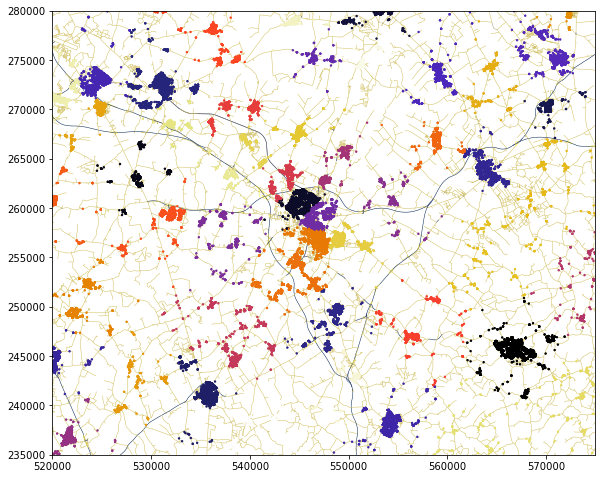

In [63]:
xmin,xmax=(520000,575000)
ymin,ymax=(235000,280000)
# xmin,xmax=(535000,560000)
# ymin,ymax=(250000,270000)

plt.figure(figsize=(7.96*float(xmax-xmin)/float(ymax-ymin),10))
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))

roads.plot(ax=plt.gca(), 
           column='formOfWay', 
           cmap=plt.cm.cividis, linewidth=0.5, zorder=0)

plt.scatter(house_prices['x'],
            house_prices['y'],
            s=2,
            c=kmeans.predict(X_train),
            cmap=plt.cm.CMRmap, zorder=1)

### DBSCAN

In [46]:
# features=['x','y',
#           'inv_sq_dist_airport', 'inv_sq_dist_runway',
#           'min_dist_station', 'min_dist_bus', 'min_dist_road', 'min_dist_river',
#           'min_dist_green',
#           'dummy_Old/New', 
#           'dummy_PPD', 
#           'dummy_PropType']
          
features=['x','y']

X_train = house_prices[features]
y_train = house_prices['Price']


Estimated number of clusters: 185
Estimated number of noise points: 184
Silhouette Coefficient: 0.449


<Figure size 864x576 with 0 Axes>

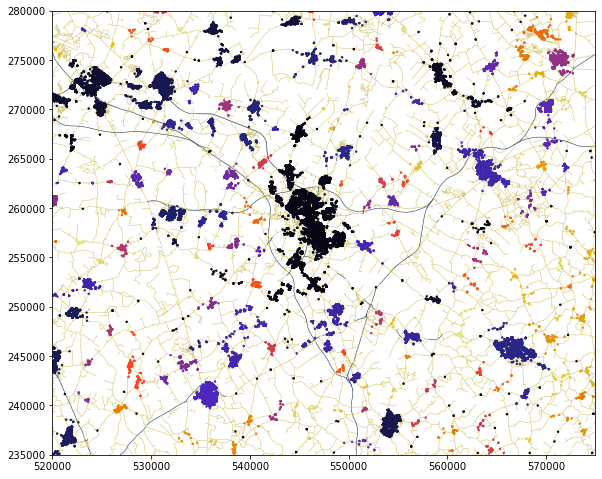

In [64]:
plt.figure(figsize=(12,8))

dbscan=DBSCAN(eps=1e3, min_samples=5).fit(X_train)


labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f" % adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, labels))

xmin,xmax=(520000,575000)
ymin,ymax=(235000,280000)
# xmin,xmax=(535000,560000)
# ymin,ymax=(250000,270000)

plt.figure(figsize=(7.96*float(xmax-xmin)/float(ymax-ymin),10))
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))

roads.plot(ax=plt.gca(), 
           column='formOfWay', 
           cmap=plt.cm.cividis, linewidth=0.5, zorder=0)

plt.scatter(house_prices['x'], 
            house_prices['y'],
            s=2,
            c=labels,
            cmap=plt.cm.CMRmap)


### OPTICS

In [78]:
features=['x','y']

X_train = house_prices[features]
y_train = house_prices['Price']

In [86]:
opt = OPTICS(min_samples=10, xi=.2)

opt.fit(X_train)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, opt.labels_))

C:\Users\Mille\.julia\conda\3\envs\geopython\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette Coefficient: 0.086


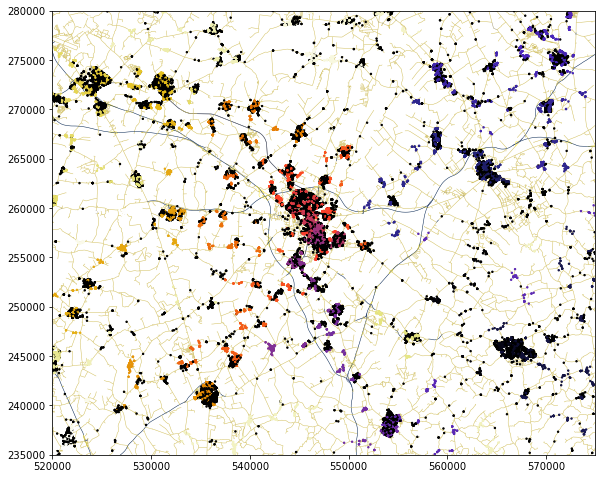

In [87]:

xmin,xmax=(520000,575000)
ymin,ymax=(235000,280000)
# xmin,xmax=(535000,560000)
# ymin,ymax=(250000,270000)

plt.figure(figsize=(7.96*float(xmax-xmin)/float(ymax-ymin),10))
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))

roads.plot(ax=plt.gca(), 
           column='formOfWay', 
           cmap=plt.cm.cividis, linewidth=0.5, zorder=0)

plt.scatter(house_prices['x'], 
            house_prices['y'],
            s=2,
            c=opt.labels_,
            cmap=plt.cm.CMRmap)

### BIRCH

In [68]:
features=['x','y']

X_train = house_prices[features]
y_train = house_prices['Price']

In [76]:
brc = Birch(n_clusters=None,
            threshold=0.1,
            branching_factor=5)
brc.fit(X_train)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, brc.predict(X_train)))

Silhouette Coefficient: 0.939


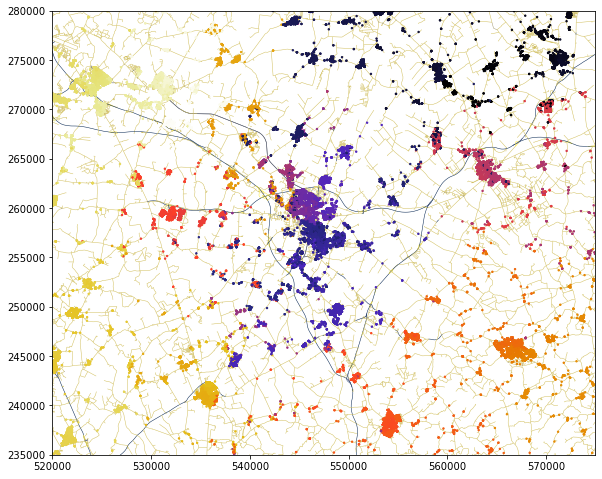

In [77]:
xmin,xmax=(520000,575000)
ymin,ymax=(235000,280000)
# xmin,xmax=(535000,560000)
# ymin,ymax=(250000,270000)

plt.figure(figsize=(7.96*float(xmax-xmin)/float(ymax-ymin),10))
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))

roads.plot(ax=plt.gca(), 
           column='formOfWay', 
           cmap=plt.cm.cividis, linewidth=0.5, zorder=0)

plt.scatter(house_prices['x'], 
            house_prices['y'],
            s=2,
            c=brc.predict(X_train),
            cmap=plt.cm.CMRmap)

## Regression
### Linear Regression

In [11]:
features=['inv_sq_dist_airport', 'inv_sq_dist_runway',
          'min_dist_station', 'min_dist_bus', 'min_dist_road', 'min_dist_river',
          'min_dist_green',
          'dummy_Old/New', 
#           'dummy_PPD', 
          'dummy_PropType']


X_train = house_prices[features]
y_train = house_prices['log_price']

normaliser = RobustScaler().fit(X_train)
X_train = normaliser.transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [12]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.24825409562399592

In [13]:
[*zip(features,reg.coef_)]

[('inv_sq_dist_airport', 1.968274820633253e-07),
 ('inv_sq_dist_runway', 8.587701772647123e-08),
 ('min_dist_station', -0.20318143134179337),
 ('min_dist_bus', 0.014243424836992069),
 ('min_dist_road', 0.007128241422594112),
 ('min_dist_river', -0.025787428380202163),
 ('min_dist_green', 0.015862360076895395),
 ('dummy_Old/New', -0.11127439664897808),
 ('dummy_PropType', 0.3662261594319105)]

In [14]:
reg.score(X_valid, y_valid)

0.2248964863402949

### Nearest-Neighbours Regression

In [17]:
features=['x','y',
          'inv_sq_dist_airport', 'inv_sq_dist_runway',
          'min_dist_station', 'min_dist_bus', 'min_dist_road', 'min_dist_river',
          'min_dist_green',
          'dummy_Old/New', 
#           'dummy_PPD', 
          'dummy_PropType']

X_train = house_prices[features]
y_train = house_prices['log_price']

normaliser = RobustScaler().fit(X_train)
X_train = normaliser.transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [18]:
max_n=40
train_r2={}
valid_r2={}
for n in range(1,max_n):
    reg = KNeighborsRegressor(n_neighbors=n,
                              weights='distance',
                              algorithm='kd_tree').fit(X_train, y_train)
    train_r2[n]=reg.score(X_train, y_train)
    valid_r2[n]=reg.score(X_valid, y_valid)

KeyboardInterrupt: 

In [ ]:
plt.plot([*range(1,max_n)],
         [train_r2[n] for n in range(1,max_n)],
         label='Training R2')
plt.plot([*range(1,max_n)],
         [valid_r2[n] for n in range(1,max_n)],
         label='Validation R2')
plt.legend()
plt.show()

In [ ]:
reg = KNeighborsRegressor(n_neighbors=15,
                          weights='distance',
                          algorithm='kd_tree').fit(X_train, y_train)
reg.score(X_test, y_test)

No real value above n=15

meaning of score in KNearestNeighbours regression

does KNNR use self point in regression?

### Tree-based Regression

In [53]:
features=['x','y',
          'inv_sq_dist_airport', 'inv_sq_dist_runway',
          'min_dist_station', 'min_dist_bus', 'min_dist_road', 
          'min_dist_river', 'min_dist_green',
          'dummy_Old/New', 
#           'dummy_PPD', 
          'dummy_PropType']

X_train = house_prices[features]
y_train = house_prices['log_price']

normaliser = RobustScaler().fit(X_train)
X_train = normaliser.transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

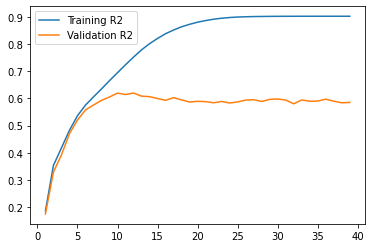

In [54]:
max_n=40
train_r2={}
valid_r2={}
for n in range(1,max_n):
    reg = DecisionTreeRegressor(max_depth=n).fit(X_train, y_train)
    train_r2[n]=reg.score(X_train, y_train)
    valid_r2[n]=reg.score(X_valid, y_valid)
    
plt.plot([*range(1,max_n)],
         [train_r2[n] for n in range(1,max_n)],
         label='Training R2')
plt.plot([*range(1,max_n)],
         [valid_r2[n] for n in range(1,max_n)],
         label='Validation R2')
plt.legend()
plt.show()


In [55]:
reg = DecisionTreeRegressor(max_depth=10).fit(X_train, y_train)
reg.score(X_test, y_test)

0.6173329072058242

## Boosting

In [39]:
from sklearn.ensemble import AdaBoostRegressor

In [40]:
features=['x','y',
          'inv_sq_dist_airport', 'inv_sq_dist_runway',
          'min_dist_station', 'min_dist_bus', 'min_dist_road', 
          'min_dist_river', 'min_dist_green',
          'dummy_Old/New', 
#           'dummy_PPD', 
          'dummy_PropType']

X_train = house_prices[features]
y_train = house_prices['log_price']

normaliser = RobustScaler().fit(X_train)
X_train = normaliser.transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

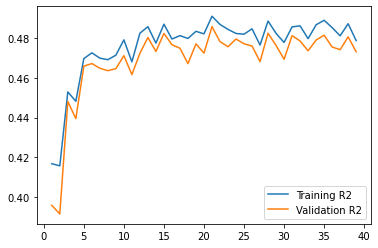

In [43]:
max_n=40
train_r2={}
valid_r2={}
for n in range(1,max_n):
    reg = AdaBoostRegressor(n_estimators=n).fit(X_train, y_train)
    train_r2[n]=reg.score(X_train, y_train)
    valid_r2[n]=reg.score(X_valid, y_valid)

    
plt.plot([*range(1,max_n)],
         [train_r2[n] for n in range(1,max_n)],
         label='Training R2')
plt.plot([*range(1,max_n)],
         [valid_r2[n] for n in range(1,max_n)],
         label='Validation R2')
plt.legend()
plt.show()